In [1]:
import glob
from timeit import default_timer as timer

import torch
import clip
from PIL import Image

import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.special

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# CONSTANTS
"""
Choose accordingly to the Model/Dataset being evaluated:
MODEL= {ViT-B-32, ViT-B-16, RN50, RN101, ViT-L-14, RN50x16} 
DATASET= {PH2, derm7pt}
"""

MODEL = "ViT-B-16"
DATASET = "PH2"
ADDITIONAL_COMMENTS = "DETAILED_CONCEPT_PROMPTS"

In [4]:
DETAILED_CONCEPT_PROMPTS = {
    "Asymmetry": ["This is dermatoscopy of an asymmetric shape with one half not mirroring the other half",  "This is dermatoscopy of asymmetrical distribution of pigmentation",  "This is dermatoscopy of irregular and non-symmetrical borders",  "This is dermatoscopy of significant asymmetry",  "This is dermatoscopy of asymmetry in the form of dissimilar features on opposite sides of the lesion"],
    "Irregular": ["This is dermatoscopy of irregular shapes or outlines",  "This is dermatoscopy of irregular distribution of pigmentation",  "This is dermatoscopy of poorly defined borders",  "This is dermatoscopy of irregular and atypical patterns",  "This is dermatoscopy of irregular features in the form of non-uniform characteristics"],
    "Erosion": ["This is dermatoscopy of surface ulceration or erosion",  "This is dermatoscopy of erosion as a crusted area on the skin",  "This is dermatoscopy of ulcerated appearance",  "This is dermatoscopy of erosion with exposed underlying tissue",  "This is dermatoscopy of erosion in the form of disrupted or absent epidermal structures"],
    "Black": ["This is dermatoscopy of dark or black pigmentation",  "This is dermatoscopy of black coloration",  "This is dermatoscopy of dark brown to black areas",  "This is dermatoscopy of black structures or pigmentation",  "This is dermatoscopy of black coloration in the form of concentrated dark areas in the lesion"],
    "Blue": ["This is dermatoscopy of blue or blue-gray coloration",  "This is dermatoscopy of blue coloration",  "This is dermatoscopy of bluish patches or areas of discoloration",  "This is dermatoscopy of blue structures or pigmentation",  "This is dermatoscopy of blue coloration in the form of bluish hues or tones in the lesion"],
    "White": ["This is dermatoscopy of white or hypopigmented coloration",  "This is dermatoscopy of white coloration",  "This is dermatoscopy of pale or depigmented patches or areas",  "This is dermatoscopy of white structures or depigmentation",  "This is dermatoscopy of white coloration in the form of reduced pigmentation in the lesion"],
    "Brown": ["This is dermatoscopy of brown or dark-brown pigmentation",  "This is dermatoscopy of brown coloration",  "This is dermatoscopy of brown patches or areas of discoloration",  "This is dermatoscopy of brown structures or pigmentation",  "This is dermatoscopy od brown coloration in the form of various shades of brown in the lesion"],
    "Multiple Colors": ["This is dermatoscopy of a combination of different colors",  "This is dermatoscopy of multiple colorations with a varied and complex appearance",  "This is dermatoscopy of a mix of different hues",  "This is dermatoscopy of diverse colors and pigmentation",  "This is dermatoscopy of multiple coloration in the form of different colored areas within the lesion"],
    "Tiny": ["This is dermatoscopy of small and minute structures or shapes",  "This is dermatoscopy of tiny shapes characterized by their small size",  "This is dermatoscopy of minuscule or small-sized patterns",  "This is dermatoscopy of tiny structures or shapes",  "This is dermatoscopy of tiny shape in the form of small and discrete features within the lesion"],
    "Regular": ["This is dermatoscopy of a regular and symmetrical pattern",  "This is dermatoscopy of regular and evenly spaced structures",  "This is dermatoscopy of uniform arrangement of patterns", "This is dermatoscopy of regular pattern in the form of symmetrical and well-defined features within the lesion"]
}

In [5]:
def calculate_similarity_score(image_features_norm,
                               prompt_target_embedding_norm,
                               prompt_ref_embedding_norm,
                               temp=1,
                               top_k=-1,
                               normalize=True):
    """
    Similarity Score used in "Fostering transparent medical image AI via an image-text foundation model grounded in medical literature"
    https://www.medrxiv.org/content/10.1101/2023.06.07.23291119v1.full.pdf
    """

    target_similarity = prompt_target_embedding_norm.float() @ image_features_norm.T.float()
    ref_similarity = prompt_ref_embedding_norm.float() @ image_features_norm.T.float()


    if top_k > 0:
        idx_target = target_similarity.argsort(dim=1, descending=True)
        target_similarity_mean = target_similarity[:,idx_target.squeeze()[:top_k]].mean(dim=1)
        
        ref_similarity_mean = ref_similarity.mean(dim=1)
    else:
        target_similarity_mean = target_similarity.mean(dim=1)
        ref_similarity_mean = ref_similarity.mean(dim=1)
    
    if normalize:
        similarity_score = scipy.special.softmax([target_similarity_mean.numpy(), ref_similarity_mean.numpy()], axis=0)[0, :].mean(axis=0)
    else:
        similarity_score = target_similarity_mean.mean(axis=0)

    return similarity_score

In [7]:
# Get image embeddings 
print(f"[INFO] DATASET: {DATASET}")
print(f"[INFO] MODEL: {MODEL}")

# Load image embeddings 
img_embeddings = np.load(f"img_embeddings/image_embeddings_{DATASET}_CLIP_{MODEL}_Segmented_Norm.npy", allow_pickle=True).item()

# Load reference embeddings
reference_embeddings = torch.from_numpy(np.load(f"reference_embeddings/reference_embeddings_{MODEL}.npy")).unsqueeze(0)

# Weights of Melanoma (Fig. 5 (I) of reference [16])
weights_melanoma = np.array([[1.9, 2.0, 3.84, 1.6, 0.15, 0.0, 2.4, 8.66, -0.05, -0.15]])

results = dict()
concept_predictions = dict()
# Iterate over images and calculate similarity
for im in img_embeddings.keys():
    img_feats = torch.from_numpy(img_embeddings[im]).unsqueeze(0)

    similarity_scores = []
    for disease_label in DETAILED_CONCEPT_PROMPTS.keys():
        # Load text embeddings of concepts descriptions
        text_feats = torch.from_numpy(np.load(f"text_embeddings/detailed_concept_embeddings_{disease_label}_{MODEL}.npy")).unsqueeze(0)

        # Calculate similarity
        similarity = calculate_similarity_score(image_features_norm=img_feats,
                                                prompt_target_embedding_norm=text_feats,
                                                prompt_ref_embedding_norm=reference_embeddings,
                                                top_k=2,
                                                temp=(1/np.exp(4.5944)),
                                                normalize=True)

        similarity_scores.append(similarity[0])

    # Calculate prediction given weights of melanoma
    y_pred = np.dot(weights_melanoma, np.array(similarity_scores))
    concept_predictions[im] = np.array(similarity_scores)
    results[im] = y_pred

[INFO] DATASET: PH2
[INFO] MODEL: ViT-B-16


In [9]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, balanced_accuracy_score, auc

if DATASET == "PH2":
    gt = pd.read_csv("../data/PH2_dataset.csv")
    
    train_images_df = pd.read_csv("../data/PH2_train.csv")
    train_images = train_images_df["images"].tolist()
    
    valiadtion_images_df = pd.read_csv("../data/PH2_validation.csv")
    validation_images = valiadtion_images_df["images"].tolist()
    
    test_images_df = pd.read_csv("../data/PH2_test.csv")
    test_images = test_images_df["images"].tolist()

elif DATASET == "derm7pt":
    gt = pd.read_csv("../data/image_classes_derm7pt.csv")
    
    train_images_df = pd.read_csv("../data/derm7pt_train_seg.csv")
    train_images = train_images_df["images"].tolist()
    
    valiadtion_images_df = pd.read_csv("../data/derm7pt_validation_seg.csv")
    validation_images = valiadtion_images_df["images"].tolist()
    
    test_images_df = pd.read_csv("../data/derm7pt_test_seg.csv")
    test_images = test_images_df["images"].tolist()

elif DATASET == "ISIC_2018":
    gt = pd.read_csv("../data/image_classes_ISIC_2018.csv")
    
    train_images_df = pd.read_csv("../data/ISIC_2018_train.csv")
    train_images = train_images_df["images"].tolist()
    
    valiadtion_images_df = pd.read_csv("../data/ISIC_2018_validation.csv")
    validation_images = valiadtion_images_df["images"].tolist()
    
    test_images_df = pd.read_csv("../data/ISIC_2018_test.csv")
    test_images = test_images_df["images"].tolist()


y_true_val = []
y_pred_probs_val = []
for im in results.keys():

    if str(im) in validation_images:
        if DATASET == "ISIC_2018":
            y_true_val.append(1 if gt.loc[gt['images'] == str(im)]['labels'].tolist()[0] == 3 else 0)
        else:
            y_true_val.append(gt.loc[gt['images'] == str(im)]['labels'].tolist()[0])
        y_pred_probs_val.append(results[im])

fpr, tpr, thresholds = roc_curve(y_true_val, y_pred_probs_val)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold, "\n")

y_true = []
y_pred = []
y_pred_probs = []
for im in results.keys():
    
    if str(im) in test_images:
        if DATASET == "ISIC_2018":
            y_true.append(1 if gt.loc[gt['images'] == str(im)]['labels'].tolist()[0] == 3 else 0)
        else:
            y_true.append(gt.loc[gt['images'] == str(im)]['labels'].tolist()[0])
        y_pred.append(1 if results[im] > optimal_threshold else 0)
        y_pred_probs.append(results[im])

print("Classification Report:")
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=["MEL", "NEV"]))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]

print("Confusion Matrix:")
print(conf_matrix, "\n")

# Calculate AUC score
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

# BACC
bacc = balanced_accuracy_score(y_true, y_pred)
print(f"BACC: {bacc}")

# Sensitivity
SE = TP / (TP + FN)
print(f"Sensitivity: {SE}")

# Specificity
SP = TN / (TN + FP)
print(f"Specificity: {SP}")

Threshold value is: 10.309924230575561 

Classification Report:
              precision    recall  f1-score   support

         MEL       1.00      0.90      0.95        20
         NEV       0.71      1.00      0.83         5

    accuracy                           0.92        25
   macro avg       0.86      0.95      0.89        25
weighted avg       0.94      0.92      0.92        25

Confusion Matrix:
[[18  2]
 [ 0  5]] 

AUC: 0.99
BACC: 0.95
Sensitivity: 1.0
Specificity: 0.9


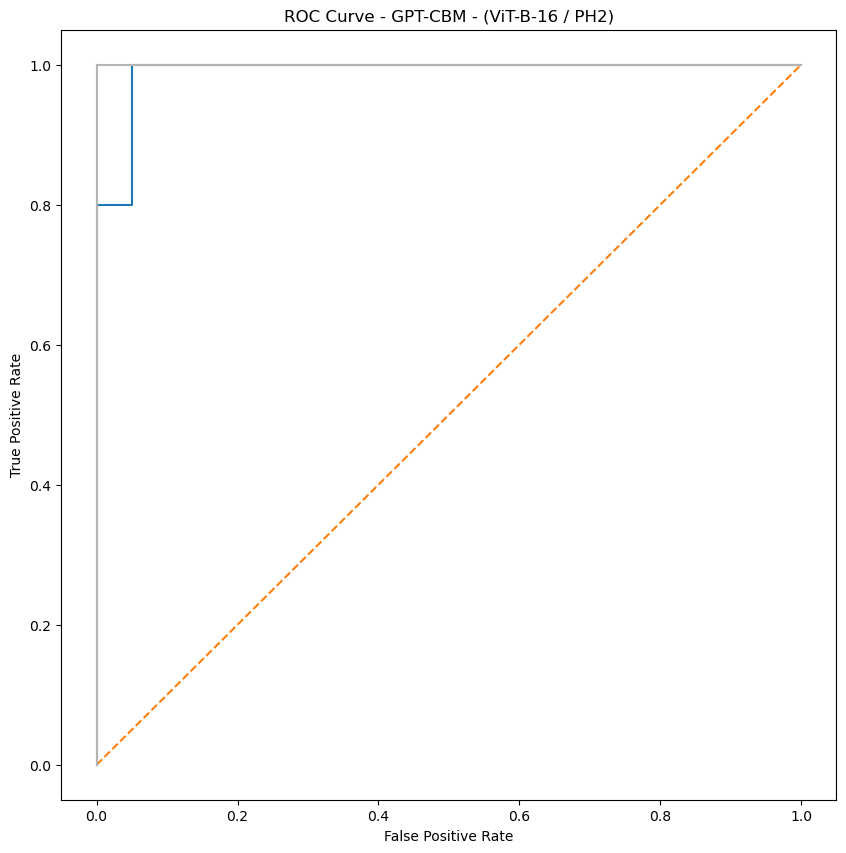

In [10]:
# Plot ROC AUC curve
import matplotlib.pyplot as plt

plt.subplots(1, figsize=(10,10))
plt.title(f'ROC Curve - GPT-CBM - ({MODEL} / {DATASET})')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()